In [2]:
from unrealcv import client
import numpy as np
import unrealcv
import random

print(unrealcv.__version__)
# Connect to the game
client = unrealcv.Client(('localhost', 9000))
client.connect() 


if not client.isconnected():
    print ('UnrealCV server is not running. Run the game from http://unrealcv.github.io first.')
else:
    # Start the server
    print ('Connection established!')
    client.request('vrun Unrealcv. Server')

client.isconnected()
print(client.request('vget /unrealcv/version'))
print(client.request('vget /unrealcv/status'))

INFO:__init__:192:Got connection confirm: b'connected to RealisticRendering2'


0.4.0
Connection established!
0.3.10
Is Listening
Client Connected
9000
Configuration
Config file: F:/unreal engine/ue/UE_4.16/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false



INFO:__init__:192:Got connection confirm: b'connected to RealisticRendering2'


-106.195 437.424 91.141
0.001 -92.000 0.000


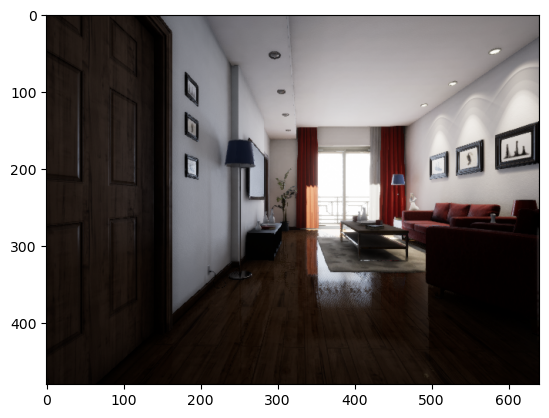

In [3]:
import cv2
import numpy as np
from unrealcv.util import read_png, read_npy
from unrealcv.automation import UE4Binary
from unrealcv import client
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline
# Connect to the game
client.connect()

# Check if the client is connected
if not client.isconnected():
    print('UnrealCV server is not running. Run the game from http://unrealcv.github.io first.')
else:
    # Capture the current image from the virtual camera
    res = client.request('vget /camera/0/lit png')
    img = read_png(res)
    plt.imshow(img)

    res = client.request('vget /camera/0/location')
    print(res)
    res = client.request('vget /camera/0/rotation')
    print(res)
    try:
        img = img.reshape((480, 640, 3))
    except ValueError:
        # resize image to target shape
        img = cv2.resize(img, (640, 480))

    # Display the captured image
    # cv2.imshow('UnrealCV Image', img)
    # cv2.waitKey(0)

In [4]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.9  # discount rate
        self.epsilon = 0.96  # exploration rate
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.batch_size = 32  # 指定 batch size
    
    @tf.autograph.experimental.do_not_convert
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, [1, *self.state_size])
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) >= self.batch_size:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    # Calculate the target Q value
                    target = (reward + self.gamma * 
                            np.amax(self.model.predict(np.expand_dims(next_state, axis=0))[0]))
                # Get the target Q value for the current state
                target_f = self.model.predict(np.expand_dims(state, axis=0))
                # Update the target Q value for the chosen action
                target_f[0][action] = target
                # Train the model on the current state and target Q value
                self.model.fit(np.expand_dims(state, axis=0), target_f, epochs=1, verbose=0)
            # Decrease epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def save(self, filename):
        self.model.save_weights(filename)

    def load(self, filename):
        self.model.load_weights(filename)

    # Define the state
    def get_state(self):
        # Capture the current image from the virtual camera
        res = client.request('vget /camera/0/lit png')
        img = read_png(res)

        # Resize image to target shape
        img = cv2.resize(img, (84, 84))

        # Convert image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize the image
        img_norm = np.divide(img_gray, 255)

        # Add channel dimension
        img_final = np.expand_dims(img_norm, axis=2)

        return img_final


2.10.0


In [5]:
import tensorflow as tf
tf.__version__


'2.10.0'

In [6]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


TensorFlow version: 2.10.0
Num GPUs: 1


In [7]:
import os
# 設定參數
num_episodes = 10
max_steps_per_episode = 100
# 定義函式以獲取物體的標籤
def get_obj_tags(obj_name):
    res = client.request(f'vget /object/{obj_name}/tags')
    return res.split(',')

# 更新攝影機位置
def update_camera_position(x, y, z):
    client.request(f'vset /camera/0/location {x} {y} {z}')

# 更新攝影機旋轉
def update_camera_rotation(pitch, yaw, roll):
    client.request(f'vset /camera/0/rotation {pitch} {yaw} {roll}')

# 獲取攝影機圖像
def get_camera_image():
    res = client.request('vget /camera/0/lit npy')
    current_pose = client.request('vget /camera/0/pose')
    x, y, z, pitch, yaw, roll = current_pose.split()
    return float(x), float(y), float(z), float(pitch), float(yaw), float(roll)

# 定義狀態大小和行動大小
action_size = 4

# 定義DQNAgent
agent = DQNAgent(state_size=(480, 640, 4), action_size=4)

# 定義試驗數量和每試驗的最大步數
num_episodes = 1
max_steps_per_episode = 1000

# 檢查是否使用GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 如果存在且不為空，則加載權重
if os.path.isfile("model_weights.h5") and os.path.getsize("model_weights.h5") > 0:
    agent.load("model_weights.h5")
else:
    print("No weights file found or file is empty")
# 定義房間範圍
min_x = -210
max_x = 200
min_y = -325
max_y = 380


# 在GPU上運行計算
with tf.device('/GPU:0'):
    # 迴圈進行試驗
    for episode in range(num_episodes):
        # 重設試驗的環境
        client.request('vset /camera/0/location 90 0 90')
        client.request('vset /camera/0/rotation 0 0 0')
        res = client.request('vget /camera/0/lit npy')
        state = read_npy(res)

        # 初始化試驗的總獎勵和步數計數器
        total_reward = 0
        step = 0

        # 迴圈進行步驟
        while True:
            # 根據當前狀態選擇行動
            action = agent.act(state)

            x, y, z, pitch, yaw, roll = get_camera_image()

            if action == 0:
            # 向前移动
                x += 50
                pitch = 0
                yaw = 0
                roll = 0
            elif action == 1:
            # 向后移动
                x -= 50
                pitch = 0
                yaw = 180
                roll = 0
            elif action == 2:
            # 向左移动
                y += 50
                pitch = 0
                yaw = -90
                roll = 0
            elif action == 3:
            # 向右移动
                y -= 50
                pitch = 0
                yaw = 90
                roll = 0

            # 更新攝像機位置和旋轉
            client.request('vset /camera/0/location {} {} {}'.format(x, y, z))
            client.request('vset /camera/0/rotation {} {} {}'.format(pitch, yaw, roll))


            # 觀察新的狀態
            res = client.request('vget /camera/0/lit npy')
            next_state = read_npy(res)

            # 檢查代理的位置是否超出房間範圍，並進行修正
            if x < min_x:
                x = min_x
            elif x > max_x:
                x = max_x

            if y < min_y:
                y = min_y
            elif y > max_y:
                y = max_y


            update_camera_position(x, y, z)
            update_camera_rotation(pitch, yaw, roll)

            # 設定獎勵為0，並且設定done為False，因為沒有可移動的物體
            reward = 0
            done = False

            # 檢查代理是否達到目標坐標
            target_positions = [(-115.0, 558.999), (-209.0, 319.999), (-209.0, -200.0)]
            target_range = 40  # 設置目標範圍

            for target_pos in target_positions:
                target_x, target_y = target_pos
                if abs(x - target_x) <= target_range and abs(y - target_y) <= target_range:
                # 如果代理到達目標坐標範圍內，則將獎勵設置為100，並設置done為True
                    reward = 100
                    done = True
                    break

            total_reward += reward
            # 檢查試驗是否結束
            if step == max_steps_per_episode or done:
                break

            # 記住經驗
            agent.remember(state, action, reward, next_state, done)

            # 更新總獎勵和步數計數器
            total_reward += reward
            step += 1

            # 更新狀態
            state = next_state
        
        agent.replay()
        # 印出試驗的總獎勵
        print(f"Episode {episode+1} complete. Total reward: {total_reward}")
        
    # 儲存權重
    agent.save("model_weights.h5")


Num GPUs Available:  1
1/1 [==============================] - 0s 15ms/step
Episode 1 complete. Total reward: 100


In [8]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 159, 32)      8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 78, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 272384)            0         
                                                                 
 dense (Dense)               (None, 512)               139461120 
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 139,541,156
Trainable params: 139,541,156
